<a href="https://colab.research.google.com/github/yash5891/Deep-Learning/blob/main/hidden_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torchvision
import torch.nn as nn
from torchvision.transforms import ToTensor
import torch.nn.functional as F
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
dataset = MNIST(root='data/', download = True, train=True, transform = ToTensor())

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:11<00:00, 899984.72it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 134730.69it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1268864.27it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 11517852.94it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
len(dataset)

60000

In [ ]:
test_dataset = MNIST(root='data/', train=False, transform = ToTensor())
len(test_dataset)

10000

image.shape: torch.Size([1, 28, 28])
Label: 5


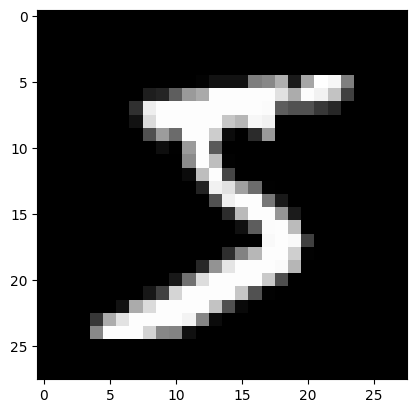

In [ ]:
image, label = dataset[0]
print('image.shape:', image.shape)
plt.imshow(image[0], cmap='gray')
print('Label:', label)

In [ ]:
val_size = 10000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(50000, 10000)

In [ ]:
batch_size=128

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


images.shape: torch.Size([128, 1, 28, 28])


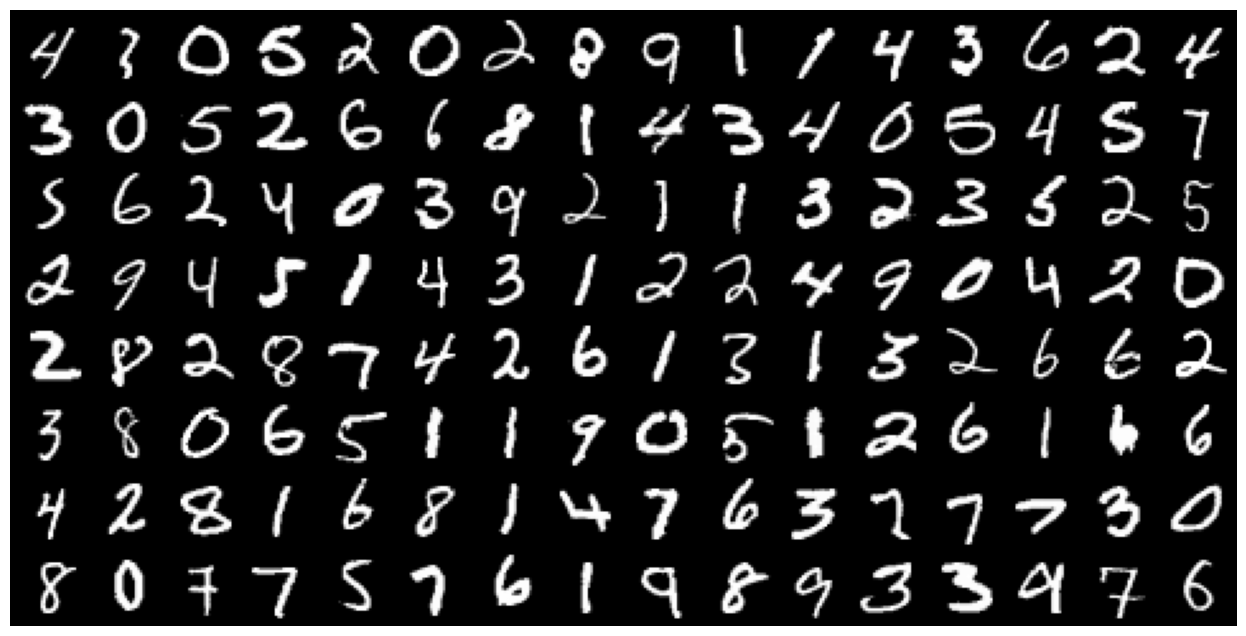

In [ ]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [ ]:
for images, labels in train_loader:
    print('images.shape:', images.shape)
    inputs = images.reshape(-1, 784)
    print('inputs.shape:', inputs.shape)
    break

images.shape: torch.Size([128, 1, 28, 28])
inputs.shape: torch.Size([128, 784])


In [ ]:
input_size = inputs.shape[-1]
hidden_size = 32

In [ ]:
layer1 = nn.Linear(input_size, hidden_size)

In [ ]:
input_size = inputs.shape[-1]
hidden_size = 32

In [ ]:
layer1_outputs = layer1(inputs)
print('layer1_outputs.shape:', layer1_outputs.shape)

layer1_outputs.shape: torch.Size([128, 32])


In [ ]:
inputs.shape

torch.Size([128, 784])

In [ ]:
layer1_outputs_direct = inputs @ layer1.weight.t() + layer1.bias
layer1_outputs_direct.shape

torch.Size([128, 32])

In [ ]:
F.relu(torch.tensor([[1, -1, 0], [-0.1, .2, 3]]))

tensor([[1.0000, 0.0000, 0.0000],
        [0.0000, 0.2000, 3.0000]])

In [ ]:
relu_outputs = F.relu(layer1_outputs)
print('min(layer1_outputs):', torch.min(layer1_outputs).item())
print('min(relu_outputs):', torch.min(relu_outputs).item())

min(layer1_outputs): -0.7839848399162292
min(relu_outputs): 0.0


In [ ]:
output_size = 10
layer2 = nn.Linear(hidden_size, output_size)

In [ ]:
layer2_outputs = layer2(relu_outputs)
print(layer2_outputs.shape)

torch.Size([128, 10])


In [ ]:
F.cross_entropy(layer2_outputs, labels)

tensor(2.3271, grad_fn=<NllLossBackward0>)

In [ ]:
# Expanded version of layer2(F.relu(layer1(inputs)))
outputs = (F.relu(inputs @ layer1.weight.t() + layer1.bias)) @ layer2.weight.t() + layer2.bias
torch.allclose(outputs, layer2_outputs, 1e-3)

True

In [ ]:
# Same as layer2(layer1(inputs))
outputs2 = (inputs @ layer1.weight.t() + layer1.bias) @ layer2.weight.t() + layer2.bias

In [ ]:
# Create a single layer to replace the two linear layers
combined_layer = nn.Linear(input_size, output_size)

combined_layer.weight.data = layer2.weight @ layer1.weight
combined_layer.bias.data = layer1.bias @ layer2.weight.t() + layer2.bias

In [ ]:
# Same as combined_layer(inputs)
outputs3 = inputs @ combined_layer.weight.t() + combined_layer.bias

torch.allclose(outputs2, outputs3, 1e-3)

True

In [ ]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class MnistModel(nn.Module):
    """Feedfoward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)

    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get predictions using output layer
        out = self.linear2(out)
        return out

    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss, 'val_acc': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


    def evaluate(self, val_loader):
      """Evaluate the model's performance on the validation set"""
      outputs = [self.validation_step(batch) for batch in val_loader]
      return self.validation_epoch_end(outputs)

In [ ]:
input_size = 784
hidden_size = 32 # you can change this
num_classes = 10

In [ ]:
model = MnistModel(input_size, hidden_size=32, out_size=num_classes)

In [ ]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [ ]:
for images, labels in train_loader:
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break

print('outputs.shape : ', outputs.shape)
print('Sample outputs :\n', outputs[:2].data)

Loss: 2.2860770225524902
outputs.shape :  torch.Size([128, 10])
Sample outputs :
 tensor([[ 0.1660,  0.0977, -0.1030, -0.0613,  0.0083, -0.1446, -0.1221,  0.0076,
          0.0440, -0.1668],
        [ 0.1524,  0.0291, -0.1233, -0.0144, -0.0579, -0.1884, -0.1336,  0.0826,
         -0.0204, -0.0946]])


In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [ ]:
for images, labels in train_loader:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([128, 1, 28, 28])
cuda:0


In [ ]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
def some_numbers():
    yield 10
    yield 20
    yield 30

for value in some_numbers():
    print(value)

10
20
30


In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)

In [ ]:
for xb, yb in val_loader:
    print('xb.device:', xb.device)
    print('yb:', yb)
    break

xb.device: cuda:0
yb: tensor([3, 2, 6, 8, 6, 9, 1, 9, 8, 9, 1, 9, 2, 6, 7, 8, 9, 2, 4, 4, 0, 3, 7, 5,
        3, 5, 3, 6, 9, 8, 1, 9, 9, 8, 6, 2, 7, 2, 1, 8, 6, 2, 9, 6, 0, 2, 7, 2,
        3, 8, 7, 6, 7, 1, 1, 8, 0, 8, 2, 3, 6, 5, 9, 8, 8, 2, 4, 9, 3, 8, 3, 3,
        1, 4, 5, 2, 6, 6, 2, 7, 9, 0, 2, 9, 8, 9, 0, 3, 5, 4, 2, 0, 4, 8, 0, 7,
        2, 7, 7, 9, 4, 1, 1, 7, 8, 3, 2, 6, 8, 7, 7, 8, 3, 2, 2, 0, 8, 9, 0, 8,
        3, 2, 5, 6, 3, 0, 6, 4, 0, 0, 8, 2, 9, 6, 4, 0, 6, 1, 6, 4, 0, 1, 4, 9,
        0, 3, 5, 9, 0, 7, 6, 7, 6, 0, 5, 0, 1, 4, 0, 0, 7, 9, 5, 0, 6, 1, 6, 7,
        8, 3, 0, 7, 2, 2, 4, 6, 7, 9, 3, 5, 8, 4, 7, 0, 0, 5, 6, 1, 9, 5, 2, 3,
        4, 9, 6, 2, 7, 3, 3, 0, 9, 6, 2, 6, 5, 0, 1, 1, 7, 0, 0, 0, 7, 3, 6, 2,
        6, 3, 6, 3, 3, 0, 6, 5, 8, 2, 3, 1, 8, 6, 0, 2, 8, 8, 3, 0, 0, 6, 2, 5,
        9, 0, 3, 0, 4, 8, 0, 5, 7, 8, 4, 9, 2, 4, 6, 4], device='cuda:0')


In [ ]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = model.evaluate(val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [ ]:
history = [model.evaluate(val_loader)]
history

[{'val_loss': 2.3008954524993896, 'val_acc': 0.107421875}]

In [ ]:
history += fit(5, 0.5, model, train_loader, val_loader)
history

Epoch [0], val_loss: 0.2499, val_acc: 0.9266
Epoch [1], val_loss: 0.1679, val_acc: 0.9493
Epoch [2], val_loss: 0.1622, val_acc: 0.9521
Epoch [3], val_loss: 0.1820, val_acc: 0.9427
Epoch [4], val_loss: 0.1532, val_acc: 0.9551


[{'val_loss': 2.3008954524993896, 'val_acc': 0.107421875},
 {'val_loss': 0.24988189339637756, 'val_acc': 0.926562488079071},
 {'val_loss': 0.1678846776485443, 'val_acc': 0.9493163824081421},
 {'val_loss': 0.1622258871793747, 'val_acc': 0.9521484375},
 {'val_loss': 0.18200930953025818, 'val_acc': 0.942675769329071},
 {'val_loss': 0.15322041511535645, 'val_acc': 0.955078125}]

In [ ]:
history+= fit(5, 0.1, model, train_loader, val_loader)
history

Epoch [0], val_loss: 0.1179, val_acc: 0.9644
Epoch [1], val_loss: 0.1161, val_acc: 0.9653
Epoch [2], val_loss: 0.1182, val_acc: 0.9658
Epoch [3], val_loss: 0.1135, val_acc: 0.9653
Epoch [4], val_loss: 0.1149, val_acc: 0.9668


[{'val_loss': 2.3008954524993896, 'val_acc': 0.107421875},
 {'val_loss': 0.24988189339637756, 'val_acc': 0.926562488079071},
 {'val_loss': 0.1678846776485443, 'val_acc': 0.9493163824081421},
 {'val_loss': 0.1622258871793747, 'val_acc': 0.9521484375},
 {'val_loss': 0.18200930953025818, 'val_acc': 0.942675769329071},
 {'val_loss': 0.15322041511535645, 'val_acc': 0.955078125},
 {'val_loss': 0.11788058280944824, 'val_acc': 0.96435546875},
 {'val_loss': 0.11608170717954636, 'val_acc': 0.96533203125},
 {'val_loss': 0.1181941032409668, 'val_acc': 0.9658203125},
 {'val_loss': 0.1135062500834465, 'val_acc': 0.96533203125},
 {'val_loss': 0.1149483472108841, 'val_acc': 0.966796875}]

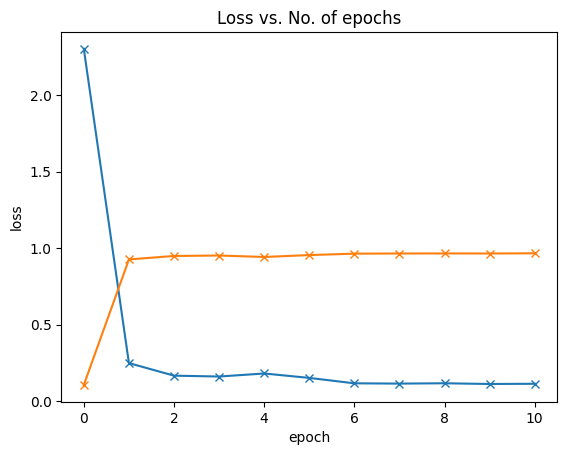

In [ ]:
losses = [x['val_loss'] for x in history]
accuracies = [x['val_acc'] for x in history]
plt.plot(losses, '-x')
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

In [ ]:
# Define test dataset
test_dataset = MNIST(root='data/',
                     train=False,
                     transform=ToTensor())

In [ ]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 7 , Predicted: 7


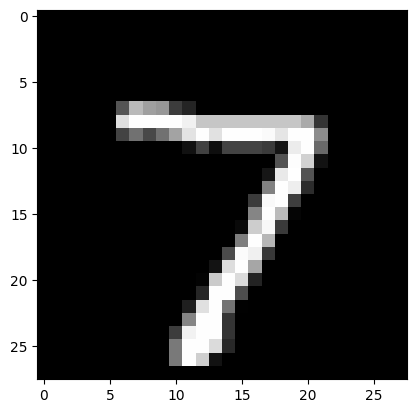

In [ ]:
img, label = test_dataset[0]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = model.evaluate(test_loader)
result

{'val_loss': 0.10231126844882965, 'val_acc': 0.969042956829071}

In [ ]:
torch.save(model.state_dict(), 'mnist-ffnn.pth')

In [ ]:
model2 = to_device(MnistModel(input_size, hidden_size,output_size),device)

In [ ]:
model2.evaluate(test_loader)

{'val_loss': 2.3014333248138428, 'val_acc': 0.0625}

In [ ]:
model2.load_state_dict(torch.load('mnist-ffnn.pth'))
model2.state_dict()

OrderedDict([('linear1.weight',
              tensor([[ 0.0089,  0.0030,  0.0225,  ...,  0.0101, -0.0260,  0.0180],
                      [ 0.0219,  0.0177, -0.0263,  ..., -0.0185, -0.0134,  0.0345],
                      [ 0.0149, -0.0208,  0.0302,  ...,  0.0176,  0.0020, -0.0005],
                      ...,
                      [ 0.0169,  0.0085, -0.0240,  ...,  0.0056, -0.0164,  0.0067],
                      [-0.0140,  0.0128,  0.0223,  ...,  0.0272, -0.0029,  0.0242],
                      [ 0.0141, -0.0111,  0.0199,  ...,  0.0178, -0.0299, -0.0122]],
                     device='cuda:0')),
             ('linear1.bias',
              tensor([ 0.1253,  0.0042, -0.1350,  0.1032,  0.0951,  0.0191,  0.4354,  0.0332,
                      -0.0135,  0.2904, -0.0131,  0.2303,  0.0917, -0.0308,  0.0953,  0.0979,
                       0.1789, -0.1305,  0.2794,  0.3149,  0.2632, -0.1879, -0.0046,  0.0067,
                       0.1219, -0.0912,  0.1040,  0.1247, -0.0215,  0.2853,  0.3604,

In [ ]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size=256), device)
result = model2.evaluate(test_loader)
result

{'val_loss': 0.10231126844882965, 'val_acc': 0.969042956829071}